# 311 Data Challenge

## Goal
- Predict the complaint type from time and user location

## Outline
The code below contains the following sections
- Section A. Dataset extraction and cleaning
- Section B. Feature engineering
- Section C. Machine Learning model
- Section D. Appendix: A few benchmark models

Load packages (see package versions in README)

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

pd.set_option('display.max_columns', 500)

Database connection function. The data were uploaded onto AWS Redshift for this study, and they are removed now

In [2]:
def query_db(query):
    '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    '''
    host = 'some_host_here'
    port = 5439
    db = '311'
    username = 'aaaaa'
    password = 'bbbbb'
    conn = psycopg2.connect(host=host, port=port, dbname=db, user=username,
    password=password)
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    rows = pd.DataFrame(rows)
    
    return rows

## Section A. Data Extraction and Cleaning

### A1. Data Extraction
- Data from 2014/01/01 to now, with location information being not null
- Query 0.25M rows for building the Machine Learning model
- Query an additional 0.25M rows to generate KNN-related features into the main dataset

In [3]:
%%time
cols = ['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name', 'complaint_type', 'descriptor',
       'location_type', 'incident_zip', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type', 'city', 'landmark', 'facility_type',
       'status', 'due_date', 'resolution_description', 'resolution_action_updated_date', 'community_board',
       'bbl', 'borough', 'x_coordinate_state_plane', 'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment', 'latitude',
       'longitude', 'location']

query = "SELECT * \
         FROM public.three_one_one \
         WHERE date_part('year', created_date) >= 2014 \
           AND x_coordinate_state_plane is not NULL \
         ORDER BY RANDOM() \
         LIMIT 500000"

# query the data
df = query_db(query)
df.columns = cols

# split the data into the main part, and the KNN-support part (to generate KNN related features into the first part)
from sklearn.model_selection import train_test_split

df, df_knn = train_test_split(df, test_size=0.5, random_state=42)
df = df.sort_values(by='created_date').reset_index(drop=True)

# only coordinates and KNN-target-variables are needed for the knn part
df_knn_address = df_knn[['x_coordinate_state_plane', 'y_coordinate_state_plane', 'location_type', 'address_type']]

Wall time: 1min 22s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 41 columns):
unique_key                        250000 non-null int64
created_date                      250000 non-null datetime64[ns]
closed_date                       243581 non-null datetime64[ns]
agency                            250000 non-null object
agency_name                       250000 non-null object
complaint_type                    250000 non-null object
descriptor                        250000 non-null object
location_type                     250000 non-null object
incident_zip                      249960 non-null float64
incident_address                  250000 non-null object
street_name                       250000 non-null object
cross_street_1                    250000 non-null object
cross_street_2                    250000 non-null object
intersection_street_1             250000 non-null object
intersection_street_2             250000 non-null object
address_type      

### A2. Data Cleaning

- I have identified missing values in incident_zip, city, street_name, incident_address, borough, etc, either as NULL or as blank string. Fortunately, both pandas groupby and LightGBM model will be able to handle both cases. Therefore, no specific treatment is applied here.
- Other common methods to impute missing values are: impute as median/mean values, add another boolean feature "is_missing", etc. I have tried both and it does not make a huge difference here.

### A3. Pre-Process the "Complaint Type"

Two things about complaint_type need to be cleaned and pre-processed
- Group a few complaint_types that are essentially the same
- Find the top 10 complaints by counts in 2019, which we will predict using the ML model

In [5]:
%%time

# Query the SQL database to get the top 100 complaint_type and their minimum and maximum created date
# because we only need complaint_type that are still active up to date
query = "SELECT t1.complaint_type, \
                t1.complaint_count, \
                t2.min_created_date, \
                t2.max_created_date \
         FROM \
            (SELECT complaint_type, \
                    COUNT(*) AS complaint_count \
             FROM public.three_one_one \
             WHERE date_part('year', created_date) = 2019 \
             GROUP BY complaint_type \
             ORDER BY complaint_count DESC \
             LIMIT 100 \
            ) t1 \
            LEFT JOIN \
            (SELECT complaint_type, \
                    MIN(created_date) AS min_created_date, \
                    MAX(created_date) AS max_created_date \
             FROM public.three_one_one \
             GROUP BY complaint_type \
            ) t2 \
            ON t1.complaint_type = t2.complaint_type \
        ORDER BY t1.complaint_count DESC"

complaint_count = query_db(query)
complaint_count.columns = ['complaint_type', 'count', 'min_created_date', 'max_created_date']
complaint_count['count'] = complaint_count['count'].astype(int)

complaint_count.head()

Wall time: 291 ms


complaint_type   count    min_created_date  \
0                  Noise - Residential  145279 2010-01-01 00:03:46   
1                       HEAT/HOT WATER  125940 2014-03-11 00:00:00   
2                      Illegal Parking  121610 2010-06-03 15:41:11   
3  Request Large Bulky Item Collection   99538 2017-08-29 15:21:00   
4                     Blocked Driveway   84622 2010-01-01 00:16:05   

     max_created_date  
0 2019-08-20 01:47:17  
1 2019-08-19 22:36:43  
2 2019-08-20 01:52:04  
3 2019-06-28 03:03:00  
4 2019-08-20 01:41:51

Group a few complaint_types as one to simplify the problem

In [6]:
def group_complaint_type(group_dict, df, complaint_count):
    '''
    Group some similar complaint types in order to better predict them
    Inputs
        - group_dict: a dictionary indicating the replacement/grouping relationship
        - df & complaint_count: two dataframes to be grouped
    Outputs
        - df & complaint_count: grouped dataframes
    '''
    
    for key, val in group_dict.items():
        
        if len(df[df['complaint_type'] == key]) > 0:
            df.loc[df['complaint_type'] == key, 'complaint_type'] = val
        
        if len(complaint_count[complaint_count['complaint_type'] == key]) > 0 \
           and len(complaint_count[complaint_count['complaint_type'] == val]) > 0:
        
            complaint_count.loc[complaint_count['complaint_type'] == val, 'count'] \
                           += complaint_count.loc[complaint_count['complaint_type'] == key, 'count'].values
        
            complaint_count.loc[complaint_count['complaint_type'] == val, 'min_created_date'] \
                           = min(complaint_count.loc[complaint_count['complaint_type'] == key, 'min_created_date'].values,\
                                complaint_count.loc[complaint_count['complaint_type'] == val, 'min_created_date'].values)
        
            complaint_count.loc[complaint_count['complaint_type'] == val, 'max_created_date'] \
                           = max(complaint_count.loc[complaint_count['complaint_type'] == key, 'max_created_date'].values,\
                                complaint_count.loc[complaint_count['complaint_type'] == val, 'max_created_date'].values)
            complaint_count = complaint_count[complaint_count['complaint_type'] != key]
    
    complaint_count = complaint_count.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return df, complaint_count

In [7]:
group_dict = {'HEATING' : 'HEAT/HOT WATER',
              'PAINT - PLASTER' : 'PAINT/PLASTER',
              'GENERAL CONSTRUCTION' : 'General Construction/Plumbing',
              'PLUMBING' : 'General Construction/Plumbing'
             }

# I tried grouping the Noise related complaints, but the accuracy is about the same. So let's keep them as separate.
#              'Noise - Commercial': 'Noise',
#              'Noise - House of Worship': 'Noise',
#              'Noise - Park': 'Noise',
#              'Noise - Residential': 'Noise',
#              'Noise - Street/Sidewalk': 'Noise',
#              'Noise - Vehicle': 'Noise',
#              'Noise Survey': 'Noise',
#              'Noise - Helicopter': 'Noise'}

df, complaint_count = group_complaint_type(group_dict, df, complaint_count)

- To train the ML model via cross-validation, one needs data from 2014-2018, or 2015-2018 due to 12-month lag features (See details later). Therefore, complaint_types that are no longer active in 2019-07 and are introduced later than 2015-01 need to be removed.
- If one plans to deploy this model, one can use the tuned hyperparameter and re-train the model using all active complaint_types without issues.

In [8]:
from datetime import datetime

start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2019-07-01', '%Y-%m-%d')

remove_list = complaint_count[(complaint_count['min_created_date'] > start_date) \
                                  | (complaint_count['max_created_date'] < end_date)]['complaint_type'].values
print("The following complaint_types are to be removed.")
print(remove_list)

complaint_count = complaint_count[(complaint_count['min_created_date'] <= start_date) \
                                  & (complaint_count['max_created_date'] > end_date)].reset_index(drop=True)

for complaint_type in remove_list:
    df = df[df['complaint_type'] != complaint_type]
    
df = df.reset_index(drop=True)

The following complaint_types are to be removed.
['Request Large Bulky Item Collection' 'Electronics Waste'
 'Derelict Vehicle' 'Abandoned Vehicle' 'Construction Safety Enforcement'
 'Dead/Dying Tree' 'DOF Property - Reduction Issue' 'Unsanitary Condition'
 'Benefit Card Replacement' 'Animal Abuse' 'Borough Office'
 'DOF Property - Request Copy' 'DOF Property - Payment Issue' 'SCRIE'
 'DOF Property - Update Account' 'Housing - Low Income Senior'
 'DOF Parking - Payment Issue' 'Snow' 'Animal-Abuse' 'Mobile Food Vendor'
 'HPD Literature Request' 'Drug Activity']


Look at the count plot of complaint_types to see how many complaint types do we need to predict

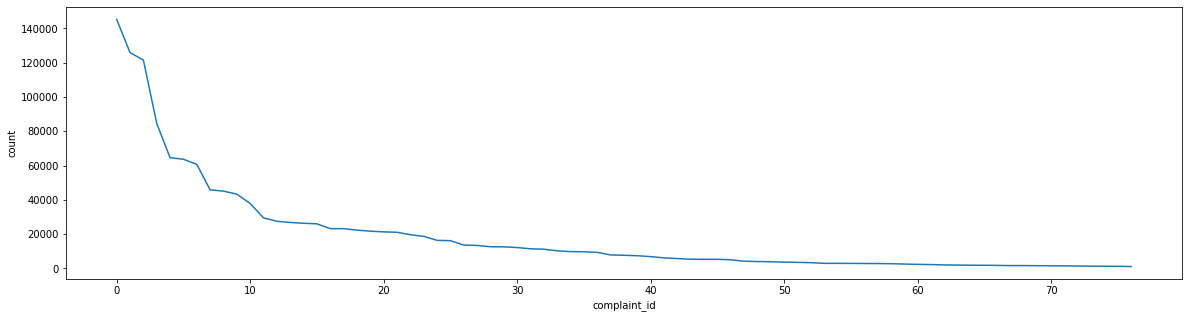

In [9]:
complaint_dict = {}

k = 0
for complaint in complaint_count['complaint_type'].unique():
    complaint_dict[complaint] = k
    k += 1
    
complaint_count['complaint_id'] = complaint_count['complaint_type'].astype(str).apply(lambda x:complaint_dict[x])

# plot complaint_id count histogram
f, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x=complaint_count['complaint_id'], y=complaint_count['count'], ax=ax)
plt.show()

The plot shows that top 20 complaint types cover most of the complaint types. For this problem, let us predict the top 10 complaint types, which explained about 60% of the complaints. Note that it will be straightforward to expand it to top 20 or 30.

In [10]:
%%time

num = 10

cat_dict = {}
for i in range(num):
    cat_dict[complaint_count.loc[i, 'complaint_type']] = i
    
df['complaint_type_id'] = df['complaint_type'].apply(lambda x : cat_dict[x] if x in cat_dict else len(cat_dict))

complaint_count['cum_ratio'] = (complaint_count['count'] / complaint_count['count'].sum()).cumsum(axis = 0)
print("%.1f%% of the complaints are covered in the top %d types" % (100*complaint_count.iloc[num]['cum_ratio'], num))

cat_dict

58.2% of the complaints are covered in the top 10 types
Wall time: 248 ms


{'Noise - Residential': 0,
 'HEAT/HOT WATER': 1,
 'Illegal Parking': 2,
 'Blocked Driveway': 3,
 'Noise - Street/Sidewalk': 4,
 'Street Condition': 5,
 'General Construction/Plumbing': 6,
 'Water System': 7,
 'Street Light Condition': 8,
 'UNSANITARY CONDITION': 9}

## Section B. Feature Engineering

### The following features will be used
- Original time and location features (created_date, latitude, longitude, x_coordinate, y_coordinate, etc.)
- Deduced location_type and address_type via KNN
- Mode + lag features: The most "popular" complaint type locally in the past X months or Y days
- Time lag features: the number of each complaint in the past X months
- Local + Lag features: Percentage of each complaint type locally in the past X months or Y days

### B1. Original location features

In [11]:
# create datetime related features
df['created_year'] = df['created_date'].dt.year
df['created_month'] = df['created_date'].dt.month
df['created_day'] = df['created_date'].dt.day
df['created_hour'] = df['created_date'].dt.hour
df['created_weekday'] = df['created_date'].dt.weekday

# fill NA for incident_zip
df['incident_zip'] = df['incident_zip'].fillna(-1)

### B2. Deduced location_type and address_type via KNN

Location_type and address_type are important in predicting the complaint_type
- However, since they are sub-fields of complaint_type, it is considered data leakage to use them.
- Therefore, I create a hierarchical model, to use KNN to predict these two features, and then use the KNN-predicted features to predict complaint_type.
- Note that the data used to train KNN model DO NOT overlap with the data to train the complaint_type model.

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# label encode the target variables
for col in ['location_type', 'address_type']:
    df_knn_address[col] = LabelEncoder().fit_transform(df_knn_address[col])

x = df_knn_address[['x_coordinate_state_plane', 'y_coordinate_state_plane']]   
y_location_type = df_knn_address['location_type']
y_address_type = df_knn_address['address_type']

# train / test split to estimate the KNN model accuracy
x_train, x_test, y_location_train, y_location_test,\
    y_address_train, y_address_test = train_test_split(x, y_location_type, y_address_type, test_size=0.2, random_state=42)

# train the knn model for location_type and address_type
# and estimate the accuracy
# note that k does not significantly impact the accuracy
from sklearn.neighbors import KNeighborsClassifier

neigh_location = KNeighborsClassifier(n_neighbors=5)
neigh_location.fit(x_train, y_location_train)
print("Accuracy of the KNN-location_type model is %.2f" % accuracy_score(y_location_test, neigh_location.predict(x_test)))

neigh_address = KNeighborsClassifier(n_neighbors=5)
neigh_address.fit(x_train, y_address_train)
print("Accuracy of the KNN-address_type model is %.2f" % accuracy_score(y_address_test, neigh_address.predict(x_test)))

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Accuracy of the KNN-location_type model is 0.40
Accuracy of the KNN-address_type model is 0.83


Although the accuracy for the location_type model is low, we can still use them to as features for the complaint_type model. Let's train them on all the KNN dataset (We held of a portion in the last block to estimate accuracy) and create two features **knn_location_type** and **knn_address_type**.

In [13]:
%%time

# train the final KNN model with all the df_knn data
neigh_location.fit(x, y_location_type)
neigh_address.fit(x, y_address_type)

df['knn_location_type'] = neigh_location.predict(df[['x_coordinate_state_plane', 'y_coordinate_state_plane']])
df['knn_address_type'] = neigh_address.predict(df[['x_coordinate_state_plane', 'y_coordinate_state_plane']])
df.head()

Wall time: 19.8 s


unique_key created_date closed_date agency  \
0    27026494   2014-01-01  2014-01-10    HPD   
1    27025817   2014-01-01  2014-01-04    HPD   
2    27027652   2014-01-01  2014-01-15    HPD   
3    27026322   2014-01-01  2014-01-29    HPD   
4    27026487   2014-01-01  2014-01-06    HPD   

                                         agency_name  \
0  Department of Housing Preservation and Develop...   
1  Department of Housing Preservation and Develop...   
2  Department of Housing Preservation and Develop...   
3  Department of Housing Preservation and Develop...   
4  Department of Housing Preservation and Develop...   

                  complaint_type    descriptor         location_type  \
0                  PAINT/PLASTER         WALLS  RESIDENTIAL BUILDING   
1                 HEAT/HOT WATER          HEAT  RESIDENTIAL BUILDING   
2                  PAINT/PLASTER       CEILING  RESIDENTIAL BUILDING   
3  General Construction/Plumbing  CERAMIC-TILE  RESIDENTIAL BUILDING   
4                 HEAT/HOT WATER          HEAT  RESIDENTIAL BUILDING   

   incident_zip       incident_address       street_name     cross_street_1  \
0       10035.0  1900 LEXINGTON AVENUE  LEXINGTON AVENUE    EAST 118 STREET   
1       10466.0    717 EAST 228 STREET   EAST 228 STREET  WHITE PLAINS ROAD   
2       11213.0   187 ROCHESTER AVENUE  ROCHESTER AVENUE     PROSPECT PLACE   
3       10468.0   2490 DAVIDSON AVENUE   DAVIDSON AVENUE  WEST FORDHAM ROAD   
4       11221.0      659 GREENE AVENUE     GREENE AVENUE    TOMPKINS AVENUE   

    cross_street_2 intersection_street_1 intersection_street_2 address_type  \
0  EAST 119 STREET                                                  ADDRESS   
1    BARNES AVENUE                                                  ADDRESS   
2       PARK PLACE                                                  ADDRESS   
3  WEST 190 STREET                                                  ADDRESS   
4    THROOP AVENUE                                                  ADDRESS   

       city landmark facility_type  status due_date  \
0  NEW YORK                    N/A  Closed      NaT   
1     BRONX                    N/A  Closed      NaT   
2  BROOKLYN                    N/A  Closed      NaT   
3     BRONX                    N/A  Closed      NaT   
4  BROOKLYN                    N/A  Closed      NaT   

                              resolution_description  \
0  The Department of Housing Preservation and Dev...   
1  The Department of Housing Preservation and Dev...   
2  The Department of Housing Preservation and Dev...   
3  The Department of Housing Preservation and Dev...   
4  The Department of Housing Preservation and Dev...   

  resolution_action_updated_date       community_board           bbl  \
0                     2014-01-10          11 MANHATTAN  1.017670e+09   
1                     2014-01-04              12 BRONX  2.048420e+09   
2                     2014-01-15  Unspecified BROOKLYN  3.013680e+09   
3                     2014-01-29     Unspecified BRONX  2.032000e+09   
4                     2014-01-06           03 BROOKLYN  3.017950e+09   

     borough  x_coordinate_state_plane  y_coordinate_state_plane  \
0  MANHATTAN                   1000700                    230764   
1      BRONX                   1023364                    263448   
2   BROOKLYN                   1004229                    184295   
3      BRONX                   1011504                    253994   
4   BROOKLYN                   1000120                    190439   

  open_data_channel_type park_facility_name park_borough vehicle_type  \
0                  PHONE        Unspecified    MANHATTAN                
1                 ONLINE        Unspecified        BRONX                
2                  PHONE        Unspecified     BROOKLYN                
3                  PHONE        Unspecified        BRONX                
4                  PHONE        Unspecified     BROOKLYN                

  taxi_company_borough taxi_pick_up_loc

### B3. Mode + lag features
- The most "popular" complaint type locally (in the same (x_coord, y_coord) bins OR in the same zip code area, etc.) in the past X months, Y days, or Z hours

In [14]:
# Create month and day index for lag feature creation

df['month_index'] = df['created_year'] * 12 + df['created_month']
df['month_index'] = df['month_index'] - df['month_index'].min()

df['day_index'] = (df['created_date'] - df['created_date'].min()).dt.days

df['hour_index'] = (df['created_date'] - df['created_date'].min()).dt.days * 24 \
                    + (df['created_date'] - df['created_date'].min()).dt.seconds // 3600

In [15]:
# Create bins for coordinates
for col in ['x_coordinate_state_plane', 'y_coordinate_state_plane']:
    df[col+'_bin'] = df[col] // 500

Generate the most "popular" complaint type locally in the past 1, 2, 3, 6, 12 months

In [16]:
def generate_mode_lag_features(df, index, groupby, target_col, lags):
    '''
    The most "popular" complaint type locally (in the same (x_coord, y_coord) bins 
             OR in the same zip code area, etc.) in the past X months, Y days, or Z hours
    
    Inputs
        - df: the input dataframe
        - index: string in one of the following: month_index, day_index, or hour_index
        - groupby: fields to groupby from, either incident_zip or (x_bin, y_bin)
        - target_col: the target column to compute the mode from, should be 'complaint_type_id' in this problem
        - lags: a list of integers indicating the number of lags
    Outputs
        - df: the output dataframe with appended features
    '''
    
    groupby = [index] + groupby
    
    for col in target_col:
        col_mode = col + '_mode'
        
        df_agg = df.groupby(groupby)[col].agg(lambda x:x.value_counts().index[0]).reset_index()
        df_agg.columns = groupby + [col_mode]
        df_agg[col_mode].fillna(-1, inplace=True)
    
        for lag in lags:
            df_agg[index] += lag
            col_lag = col_mode + '_lag_' + index + '_' + str(lag)
            df_agg[col_lag] = df_agg[col_mode]
            df = df.merge(df_agg[groupby+[col_lag]], on=groupby, how='left')
            df_agg[index] -= lag
            df[col_lag].fillna(-1, inplace=True)
            
    return df

In [17]:
%%time

# This computation is time-consuming, and spoiler alert, it does NOT help too much with the final prediction...
# So let's just calculate the following as an example
# Just keep in mind that we can potentially have a lot more combination of groupby, index, and lags

groupby = ['x_coordinate_state_plane_bin', 'y_coordinate_state_plane_bin']

df = generate_mode_lag_features(df, 
                                index='day_index',
                                groupby=groupby,
                                target_col=['complaint_type_id'],
                                lags=[1])

df = generate_mode_lag_features(df, 
                                index='hour_index',
                                groupby=groupby,
                                target_col=['complaint_type_id'],
                                lags=[1])

Wall time: 8min 29s


### B4. Local + Lag percentage features
- Percentage of each complaint type locally (in the same (x,y) bins or in the same zip code area) in the past X months or Y days

In [18]:
def create_pct_features(df, groupby, index, lags):
    '''
    The percentage of each complaint type locally (in the same (x_coord, y_coord) bins 
             OR in the same zip code area, etc.) in the past X months, Y days, or Z hours
    The main difference compared to the 'generate_mode_lag_features' function is that
    this one computes percentage of each complaint type
    
    Inputs
        - df: the input dataframe
        - index: string in one of the following: month_index, day_index, or hour_index
        - groupby: fields to groupby from, either incident_zip or (x_bin, y_bin)
        - lags: a list of integers indicating the number of lags
    Outputs
        - df: the output dataframe with appended features
    '''
    
    features = []
    groupby_str = "_".join(groupby)
    
    df_lag = df.groupby([index]+groupby).agg({'unique_key':'count'}).add_prefix('cnt_%s_%s_' % (index,groupby_str)).reset_index()
    col_sum = 'cnt_%s_%s_unique_key' % (index, groupby_str)
    features.append(col_sum)

    # for each complaint type, compute the percentage and append it
    for i in range(df['complaint_type_id'].max()+1):
        df_agg = df[df['complaint_type_id'] == i].groupby([index]+groupby).agg({'unique_key':'count'}).add_prefix('pct_%s_%d_' % (groupby_str, i)).reset_index()
        col = 'pct_%s_%d_unique_key' % (groupby_str, i)

        df_lag = df_lag.merge(df_agg, on=[index]+groupby, how='left')
            
        df_lag[col].fillna(0, inplace=True)
        df_lag[col] /= df_lag[col_sum]
        features.append(col)
    
    # let's lag it
    for lag in lags:
        col_names_lag = [col + '_lag_' + index + '_' + str(lag) for col in features]
        df_lag.columns = [index] + groupby + col_names_lag
        df_lag[index] += lag
        df = df.merge(df_lag, on=[index] + groupby, how='left')
        df_lag[index] -= lag
    
        df[col_names_lag].fillna(0, inplace=True)
    
    return df

In [19]:
%%time

for groupby in [['incident_zip'], ['open_data_channel_type'], ['street_name'], ['created_hour'], ['borough']]:

    df = create_pct_features(df, groupby, index='day_index', lags=[1])
    df = create_pct_features(df, groupby, index='month_index', lags=[1, 6, 12])
    
df.head()

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Wall time: 3min 41s


unique_key created_date closed_date agency  \
0    27026494   2014-01-01  2014-01-10    HPD   
1    27025817   2014-01-01  2014-01-04    HPD   
2    27027652   2014-01-01  2014-01-15    HPD   
3    27026322   2014-01-01  2014-01-29    HPD   
4    27026487   2014-01-01  2014-01-06    HPD   

                                         agency_name  \
0  Department of Housing Preservation and Develop...   
1  Department of Housing Preservation and Develop...   
2  Department of Housing Preservation and Develop...   
3  Department of Housing Preservation and Develop...   
4  Department of Housing Preservation and Develop...   

                  complaint_type    descriptor         location_type  \
0                  PAINT/PLASTER         WALLS  RESIDENTIAL BUILDING   
1                 HEAT/HOT WATER          HEAT  RESIDENTIAL BUILDING   
2                  PAINT/PLASTER       CEILING  RESIDENTIAL BUILDING   
3  General Construction/Plumbing  CERAMIC-TILE  RESIDENTIAL BUILDING   
4                 HEAT/HOT WATER          HEAT  RESIDENTIAL BUILDING   

   incident_zip       incident_address       street_name     cross_street_1  \
0       10035.0  1900 LEXINGTON AVENUE  LEXINGTON AVENUE    EAST 118 STREET   
1       10466.0    717 EAST 228 STREET   EAST 228 STREET  WHITE PLAINS ROAD   
2       11213.0   187 ROCHESTER AVENUE  ROCHESTER AVENUE     PROSPECT PLACE   
3       10468.0   2490 DAVIDSON AVENUE   DAVIDSON AVENUE  WEST FORDHAM ROAD   
4       11221.0      659 GREENE AVENUE     GREENE AVENUE    TOMPKINS AVENUE   

    cross_street_2 intersection_street_1 intersection_street_2 address_type  \
0  EAST 119 STREET                                                  ADDRESS   
1    BARNES AVENUE                                                  ADDRESS   
2       PARK PLACE                                                  ADDRESS   
3  WEST 190 STREET                                                  ADDRESS   
4    THROOP AVENUE                                                  ADDRESS   

       city landmark facility_type  status due_date  \
0  NEW YORK                    N/A  Closed      NaT   
1     BRONX                    N/A  Closed      NaT   
2  BROOKLYN                    N/A  Closed      NaT   
3     BRONX                    N/A  Closed      NaT   
4  BROOKLYN                    N/A  Closed      NaT   

                              resolution_description  \
0  The Department of Housing Preservation and Dev...   
1  The Department of Housing Preservation and Dev...   
2  The Department of Housing Preservation and Dev...   
3  The Department of Housing Preservation and Dev...   
4  The Department of Housing Preservation and Dev...   

  resolution_action_updated_date       community_board           bbl  \
0                     2014-01-10          11 MANHATTAN  1.017670e+09   
1                     2014-01-04              12 BRONX  2.048420e+09   
2                     2014-01-15  Unspecified BROOKLYN  3.013680e+09   
3                     2014-01-29     Unspecified BRONX  2.032000e+09   
4                     2014-01-06           03 BROOKLYN  3.017950e+09   

     borough  x_coordinate_state_plane  y_coordinate_state_plane  \
0  MANHATTAN                   1000700                    230764   
1      BRONX                   1023364                    263448   
2   BROOKLYN                   1004229                    184295   
3      BRONX                   1011504                    253994   
4   BROOKLYN                   1000120                    190439   

  open_data_channel_type park_facility_name park_borough vehicle_type  \
0                  PHONE        Unspecified    MANHATTAN                
1                 ONLINE        Unspecified        BRONX                
2                  PHONE        Unspecified     BROOKLYN                
3                  PHONE        Unspecified        BRONX                
4                  PHONE        Unspecified     BROOKLYN                

  taxi_company_borough taxi_pick_up_loc

Save the data before proceeding to the ML model training

In [20]:
df.to_pickle('../processed_data/df_20190924.pkl')

## Section C. Machine Learning Model
- Note that I train the BEST model that contains all the features below
- For benchmark models (Round 0, Round 1, Round 2), please see the appendix blocks

In [21]:
df = pd.read_pickle('../processed_data/df_20190924.pkl')

### C1. Feature Selection

First see what features we have and semi-manually select the ones we would like to have. I will select ALL of them and use the feature_fraction hyperparameter in LightGBM to prevent overfitting

In [22]:
df.columns.values

array(['unique_key', 'created_date', 'closed_date', 'agency',
       'agency_name', 'complaint_type', 'descriptor', 'location_type',
       'incident_zip', 'incident_address', 'street_name',
       'cross_street_1', 'cross_street_2', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'landmark',
       'facility_type', 'status', 'due_date', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl',
       'borough', 'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'latitude', 'longitude', 'location',
       'complaint_type_id', 'created_year', 'created_month',
       'created_day', 'created_hour', 'created_weekday',
       'knn_location_type', 'knn_address_type', 'month_ind

In [44]:
feature_mode_lag = ['complaint_type_id_mode_lag_day_index_1',
       'complaint_type_id_mode_lag_hour_index_1'
                   ]

feature_pct_lag = ['cnt_day_index_incident_zip_unique_key_lag_day_index_1',
       'pct_incident_zip_0_unique_key_lag_day_index_1',
       'pct_incident_zip_1_unique_key_lag_day_index_1',
       'pct_incident_zip_2_unique_key_lag_day_index_1',
       'pct_incident_zip_3_unique_key_lag_day_index_1',
       'pct_incident_zip_4_unique_key_lag_day_index_1',
       'pct_incident_zip_5_unique_key_lag_day_index_1',
       'pct_incident_zip_6_unique_key_lag_day_index_1',
       'pct_incident_zip_7_unique_key_lag_day_index_1',
       'pct_incident_zip_8_unique_key_lag_day_index_1',
       'pct_incident_zip_9_unique_key_lag_day_index_1',
       'pct_incident_zip_10_unique_key_lag_day_index_1',
       'cnt_month_index_incident_zip_unique_key_lag_month_index_1',
       'pct_incident_zip_0_unique_key_lag_month_index_1',
       'pct_incident_zip_1_unique_key_lag_month_index_1',
       'pct_incident_zip_2_unique_key_lag_month_index_1',
       'pct_incident_zip_3_unique_key_lag_month_index_1',
       'pct_incident_zip_4_unique_key_lag_month_index_1',
       'pct_incident_zip_5_unique_key_lag_month_index_1',
       'pct_incident_zip_6_unique_key_lag_month_index_1',
       'pct_incident_zip_7_unique_key_lag_month_index_1',
       'pct_incident_zip_8_unique_key_lag_month_index_1',
       'pct_incident_zip_9_unique_key_lag_month_index_1',
       'pct_incident_zip_10_unique_key_lag_month_index_1',
       'cnt_month_index_incident_zip_unique_key_lag_month_index_6',
       'pct_incident_zip_0_unique_key_lag_month_index_6',
       'pct_incident_zip_1_unique_key_lag_month_index_6',
       'pct_incident_zip_2_unique_key_lag_month_index_6',
       'pct_incident_zip_3_unique_key_lag_month_index_6',
       'pct_incident_zip_4_unique_key_lag_month_index_6',
       'pct_incident_zip_5_unique_key_lag_month_index_6',
       'pct_incident_zip_6_unique_key_lag_month_index_6',
       'pct_incident_zip_7_unique_key_lag_month_index_6',
       'pct_incident_zip_8_unique_key_lag_month_index_6',
       'pct_incident_zip_9_unique_key_lag_month_index_6',
       'pct_incident_zip_10_unique_key_lag_month_index_6',
       'cnt_month_index_incident_zip_unique_key_lag_month_index_12',
       'pct_incident_zip_0_unique_key_lag_month_index_12',
       'pct_incident_zip_1_unique_key_lag_month_index_12',
       'pct_incident_zip_2_unique_key_lag_month_index_12',
       'pct_incident_zip_3_unique_key_lag_month_index_12',
       'pct_incident_zip_4_unique_key_lag_month_index_12',
       'pct_incident_zip_5_unique_key_lag_month_index_12',
       'pct_incident_zip_6_unique_key_lag_month_index_12',
       'pct_incident_zip_7_unique_key_lag_month_index_12',
       'pct_incident_zip_8_unique_key_lag_month_index_12',
       'pct_incident_zip_9_unique_key_lag_month_index_12',
       'pct_incident_zip_10_unique_key_lag_month_index_12',
       'cnt_day_index_open_data_channel_type_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_0_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_1_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_2_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_3_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_4_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_5_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_6_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_7_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_8_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_9_unique_key_lag_day_index_1',
       'pct_open_data_channel_type_10_unique_key_lag_day_index_1',
       'cnt_month_index_open_data_channel_type_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_0_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_1_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_2_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_3_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_4_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_5_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_6_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_7_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_8_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_9_unique_key_lag_month_index_1',
       'pct_open_data_channel_type_10_unique_key_lag_month_index_1',
       'cnt_month_index_open_data_channel_type_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_0_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_1_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_2_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_3_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_4_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_5_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_6_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_7_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_8_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_9_unique_key_lag_month_index_6',
       'pct_open_data_channel_type_10_unique_key_lag_month_index_6',
       'cnt_month_index_open_data_channel_type_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_0_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_1_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_2_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_3_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_4_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_5_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_6_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_7_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_8_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_9_unique_key_lag_month_index_12',
       'pct_open_data_channel_type_10_unique_key_lag_month_index_12',
       'cnt_day_index_street_name_unique_key_lag_day_index_1',
       'pct_street_name_0_unique_key_lag_day_index_1',
       'pct_street_name_1_unique_key_lag_day_index_1',
       'pct_street_name_2_unique_key_lag_day_index_1',
       'pct_street_name_3_unique_key_lag_day_index_1',
       'pct_street_name_4_unique_key_lag_day_index_1',
       'pct_street_name_5_unique_key_lag_day_index_1',
       'pct_street_name_6_unique_key_lag_day_index_1',
       'pct_street_name_7_unique_key_lag_day_index_1',
       'pct_street_name_8_unique_key_lag_day_index_1',
       'pct_street_name_9_unique_key_lag_day_index_1',
       'pct_street_name_10_unique_key_lag_day_index_1',
       'cnt_month_index_street_name_unique_key_lag_month_index_1',
       'pct_street_name_0_unique_key_lag_month_index_1',
       'pct_street_name_1_unique_key_lag_month_index_1',
       'pct_street_name_2_unique_key_lag_month_index_1',
       'pct_street_name_3_unique_key_lag_month_index_1',
       'pct_street_name_4_unique_key_lag_month_index_1',
       'pct_street_name_5_unique_key_lag_month_index_1',
       'pct_street_name_6_unique_key_lag_month_index_1',
       'pct_street_name_7_unique_key_lag_month_index_1',
       'pct_street_name_8_unique_key_lag_month_index_1',
       'pct_street_name_9_unique_key_lag_month_index_1',
       'pct_street_name_10_unique_key_lag_month_index_1',
       'cnt_month_index_street_name_unique_key_lag_month_index_6',
       'pct_street_name_0_unique_key_lag_month_index_6',
       'pct_street_name_1_unique_key_lag_month_index_6',
       'pct_street_name_2_unique_key_lag_month_index_6',
       'pct_street_name_3_unique_key_lag_month_index_6',
       'pct_street_name_4_unique_key_lag_month_index_6',
       'pct_street_name_5_unique_key_lag_month_index_6',
       'pct_street_name_6_unique_key_lag_month_index_6',
       'pct_street_name_7_unique_key_lag_month_index_6',
       'pct_street_name_8_unique_key_lag_month_index_6',
       'pct_street_name_9_unique_key_lag_month_index_6',
       'pct_street_name_10_unique_key_lag_month_index_6',
       'cnt_month_index_street_name_unique_key_lag_month_index_12',
       'pct_street_name_0_unique_key_lag_month_index_12',
       'pct_street_name_1_unique_key_lag_month_index_12',
       'pct_street_name_2_unique_key_lag_month_index_12',
       'pct_street_name_3_unique_key_lag_month_index_12',
       'pct_street_name_4_unique_key_lag_month_index_12',
       'pct_street_name_5_unique_key_lag_month_index_12',
       'pct_street_name_6_unique_key_lag_month_index_12',
       'pct_street_name_7_unique_key_lag_month_index_12',
       'pct_street_name_8_unique_key_lag_month_index_12',
       'pct_street_name_9_unique_key_lag_month_index_12',
       'pct_street_name_10_unique_key_lag_month_index_12',
       'cnt_day_index_created_hour_unique_key_lag_day_index_1',
       'pct_created_hour_0_unique_key_lag_day_index_1',
       'pct_created_hour_1_unique_key_lag_day_index_1',
       'pct_created_hour_2_unique_key_lag_day_index_1',
       'pct_created_hour_3_unique_key_lag_day_index_1',
       'pct_created_hour_4_unique_key_lag_day_index_1',
       'pct_created_hour_5_unique_key_lag_day_index_1',
       'pct_created_hour_6_unique_key_lag_day_index_1',
       'pct_created_hour_7_unique_key_lag_day_index_1',
       'pct_created_hour_8_unique_key_lag_day_index_1',
       'pct_created_hour_9_unique_key_lag_day_index_1',
       'pct_created_hour_10_unique_key_lag_day_index_1',
       'cnt_month_index_created_hour_unique_key_lag_month_index_1',
       'pct_created_hour_0_unique_key_lag_month_index_1',
       'pct_created_hour_1_unique_key_lag_month_index_1',
       'pct_created_hour_2_unique_key_lag_month_index_1',
       'pct_created_hour_3_unique_key_lag_month_index_1',
       'pct_created_hour_4_unique_key_lag_month_index_1',
       'pct_created_hour_5_unique_key_lag_month_index_1',
       'pct_created_hour_6_unique_key_lag_month_index_1',
       'pct_created_hour_7_unique_key_lag_month_index_1',
       'pct_created_hour_8_unique_key_lag_month_index_1',
       'pct_created_hour_9_unique_key_lag_month_index_1',
       'pct_created_hour_10_unique_key_lag_month_index_1',
       'cnt_month_index_created_hour_unique_key_lag_month_index_6',
       'pct_created_hour_0_unique_key_lag_month_index_6',
       'pct_created_hour_1_unique_key_lag_month_index_6',
       'pct_created_hour_2_unique_key_lag_month_index_6',
       'pct_created_hour_3_unique_key_lag_month_index_6',
       'pct_created_hour_4_unique_key_lag_month_index_6',
       'pct_created_hour_5_unique_key_lag_month_index_6',
       'pct_created_hour_6_unique_key_lag_month_index_6',
       'pct_created_hour_7_unique_key_lag_month_index_6',
       'pct_created_hour_8_unique_key_lag_month_index_6',
       'pct_created_hour_9_unique_key_lag_month_index_6',
       'pct_created_hour_10_unique_key_lag_month_index_6',
       'cnt_month_index_created_hour_unique_key_lag_month_index_12',
       'pct_created_hour_0_unique_key_lag_month_index_12',
       'pct_created_hour_1_unique_key_lag_month_index_12',
       'pct_created_hour_2_unique_key_lag_month_index_12',
       'pct_created_hour_3_unique_key_lag_month_index_12',
       'pct_created_hour_4_unique_key_lag_month_index_12',
       'pct_created_hour_5_unique_key_lag_month_index_12',
       'pct_created_hour_6_unique_key_lag_month_index_12',
       'pct_created_hour_7_unique_key_lag_month_index_12',
       'pct_created_hour_8_unique_key_lag_month_index_12',
       'pct_created_hour_9_unique_key_lag_month_index_12',
       'pct_created_hour_10_unique_key_lag_month_index_12',
       'cnt_day_index_borough_unique_key_lag_day_index_1',
       'pct_borough_0_unique_key_lag_day_index_1',
       'pct_borough_1_unique_key_lag_day_index_1',
       'pct_borough_2_unique_key_lag_day_index_1',
       'pct_borough_3_unique_key_lag_day_index_1',
       'pct_borough_4_unique_key_lag_day_index_1',
       'pct_borough_5_unique_key_lag_day_index_1',
       'pct_borough_6_unique_key_lag_day_index_1',
       'pct_borough_7_unique_key_lag_day_index_1',
       'pct_borough_8_unique_key_lag_day_index_1',
       'pct_borough_9_unique_key_lag_day_index_1',
       'pct_borough_10_unique_key_lag_day_index_1',
       'cnt_month_index_borough_unique_key_lag_month_index_1',
       'pct_borough_0_unique_key_lag_month_index_1',
       'pct_borough_1_unique_key_lag_month_index_1',
       'pct_borough_2_unique_key_lag_month_index_1',
       'pct_borough_3_unique_key_lag_month_index_1',
       'pct_borough_4_unique_key_lag_month_index_1',
       'pct_borough_5_unique_key_lag_month_index_1',
       'pct_borough_6_unique_key_lag_month_index_1',
       'pct_borough_7_unique_key_lag_month_index_1',
       'pct_borough_8_unique_key_lag_month_index_1',
       'pct_borough_9_unique_key_lag_month_index_1',
       'pct_borough_10_unique_key_lag_month_index_1',
       'cnt_month_index_borough_unique_key_lag_month_index_6',
       'pct_borough_0_unique_key_lag_month_index_6',
       'pct_borough_1_unique_key_lag_month_index_6',
       'pct_borough_2_unique_key_lag_month_index_6',
       'pct_borough_3_unique_key_lag_month_index_6',
       'pct_borough_4_unique_key_lag_month_index_6',
       'pct_borough_5_unique_key_lag_month_index_6',
       'pct_borough_6_unique_key_lag_month_index_6',
       'pct_borough_7_unique_key_lag_month_index_6',
       'pct_borough_8_unique_key_lag_month_index_6',
       'pct_borough_9_unique_key_lag_month_index_6',
       'pct_borough_10_unique_key_lag_month_index_6',
       'cnt_month_index_borough_unique_key_lag_month_index_12',
       'pct_borough_0_unique_key_lag_month_index_12',
       'pct_borough_1_unique_key_lag_month_index_12',
       'pct_borough_2_unique_key_lag_month_index_12',
       'pct_borough_3_unique_key_lag_month_index_12',
       'pct_borough_4_unique_key_lag_month_index_12',
       'pct_borough_5_unique_key_lag_month_index_12',
       'pct_borough_6_unique_key_lag_month_index_12',
       'pct_borough_7_unique_key_lag_month_index_12',
       'pct_borough_8_unique_key_lag_month_index_12',
       'pct_borough_9_unique_key_lag_month_index_12',
       'pct_borough_10_unique_key_lag_month_index_12']

In [24]:
# time related features
feature_time = ['hour_index', 'day_index', 'month_index', 'created_year', 'created_month',
                'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

# knn features
feature_knn = ['knn_address_type', 'knn_location_type']

# mode lag and pct lag features are selected in the above block
#feature_mode_lag
#feature_pct_lag

feature_target = ['complaint_type_id']

# feature selection
x = df[feature_time + feature_location + feature_others + feature_knn + feature_mode_lag + feature_pct_lag + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x[feature_mode_lag] = x[feature_mode_lag].fillna(-1.0)
x[feature_pct_lag] = x[feature_pct_lag].fillna(-1.0)
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
# lightGBM will handle this, should be better than label encoding
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')
    
x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

### C2. Time-Series Train/Test Split

Split into the training set (will do time-series cross-validation within) and the test set (used to evaluate the performance)

In [25]:
x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

### C3. Set up the LightGBM model and hyperparameter tuning

In [26]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

# Set up hyperparamter ranges
param_tune ={'learning_rate': sp_uniform(loc=0.01, scale=0.05),
             'num_leaves': sp_randint(6, 50),
             'min_data_in_leaf': sp_randint(5, 100),
             'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'feature_fraction': sp_uniform(loc=0.6, scale=0.4),
             'reg_alpha': [0, 1e-1, 1, 5, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 50, 100]
            }
        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 100}

Hyperparameter tuning
- Perform hyperparameter tuning using randomized search with 3-fold time-series cross-validation
- For time's sake, I will not show the output of this block and hard-code the best model from the hyperparameter search in the next block

In [27]:
%%time

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

clf = lgb.LGBMClassifier(**params)

time_split = TimeSeriesSplit(n_splits=3)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_tune, 
    n_iter=20,
    scoring='f1_weighted',
    cv=time_split,
    refit=True,
    random_state=2019,
    verbose=True)

# uncomment the next line to perform hyperparameter tuning (WARNING: Could take a few hours to run!)
#gs.fit(x_train, y_train, **fit_params)

Wall time: 53 ms


Output the best score and the best hyperparameter, which I hard-coded in the next block.

In [28]:
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

With the hard-coded best hyperparameters, re-train the model using all data from training + evaluation set.

In [29]:
%%time

# best parameters
opt_parameters = {'subsample': 0.63,
                  'feature_fraction': 0.92,
                  'learning_rate': 0.046,
                  'min_child_weight': 0.001,
                  'min_data_in_leaf': 32,
                  'num_leaves': 36,
                  'reg_alpha': 0,
                  'reg_lambda': 0.1} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 40 rounds.
[100]	train's multi_logloss: 1.14308	valid's multi_logloss: 1.35324
[200]	train's multi_logloss: 1.00422	valid's multi_logloss: 1.32442
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.989109	valid's multi_logloss: 1.324
Wall time: 9min 29s


LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.92, importance_type='split',
               learning_rate=0.046, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, nthread=4, num_class=11, num_leaves=36,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.1, silent=True, subsample=0.63,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

### C4. ML model evaluation
- classification_report (accuracy, f1_score, etc.)
- confusion_matrix
- feature_importance

The following block outputs the classification report

In [30]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.52      0.48      0.50      2911
               HEAT/HOT WATER       0.53      0.49      0.51      2562
              Illegal Parking       0.48      0.26      0.34      2334
             Blocked Driveway       0.37      0.24      0.29      1611
      Noise - Street/Sidewalk       0.55      0.25      0.35      1250
             Street Condition       0.42      0.18      0.26      1151
General Construction/Plumbing       0.23      0.01      0.03      1130
                 Water System       0.33      0.01      0.01       941
       Street Light Condition       0.64      0.58      0.61       523
         UNSANITARY CONDITION       0.19      0.01      0.02       883
                       Others       0.56      0.84      0.67     12427

                     accuracy                           0.54     27723
                    macro avg       0.44      0.30      0.32     27723
    

The next block computes the confusion matrix with the help of a helper function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

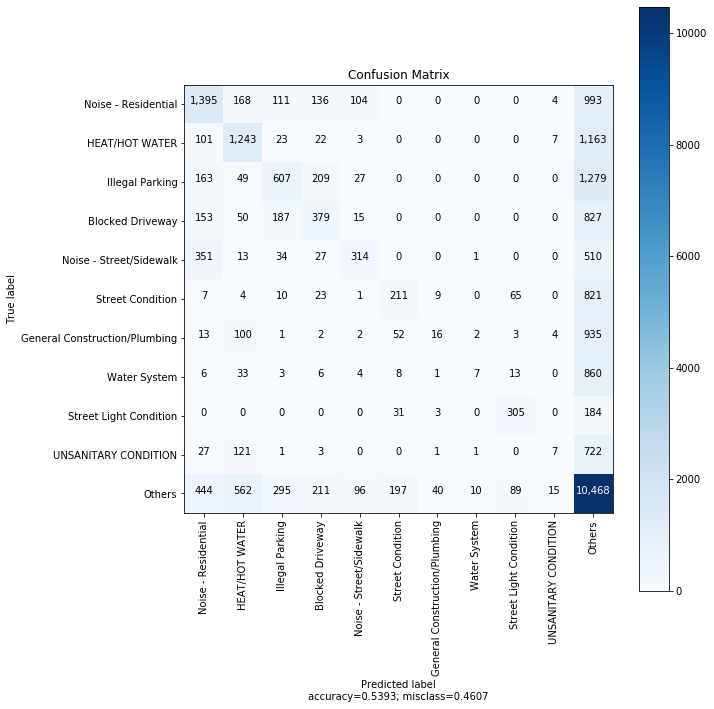

In [31]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
  


cm = confusion_matrix(y_test,
                      clf_sw.predict(x_test),
                      labels=range(len(cat_dict)+1))

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = list(cat_dict)+['Others'],
                      title        = "Confusion Matrix")

The next block computes the feature importance

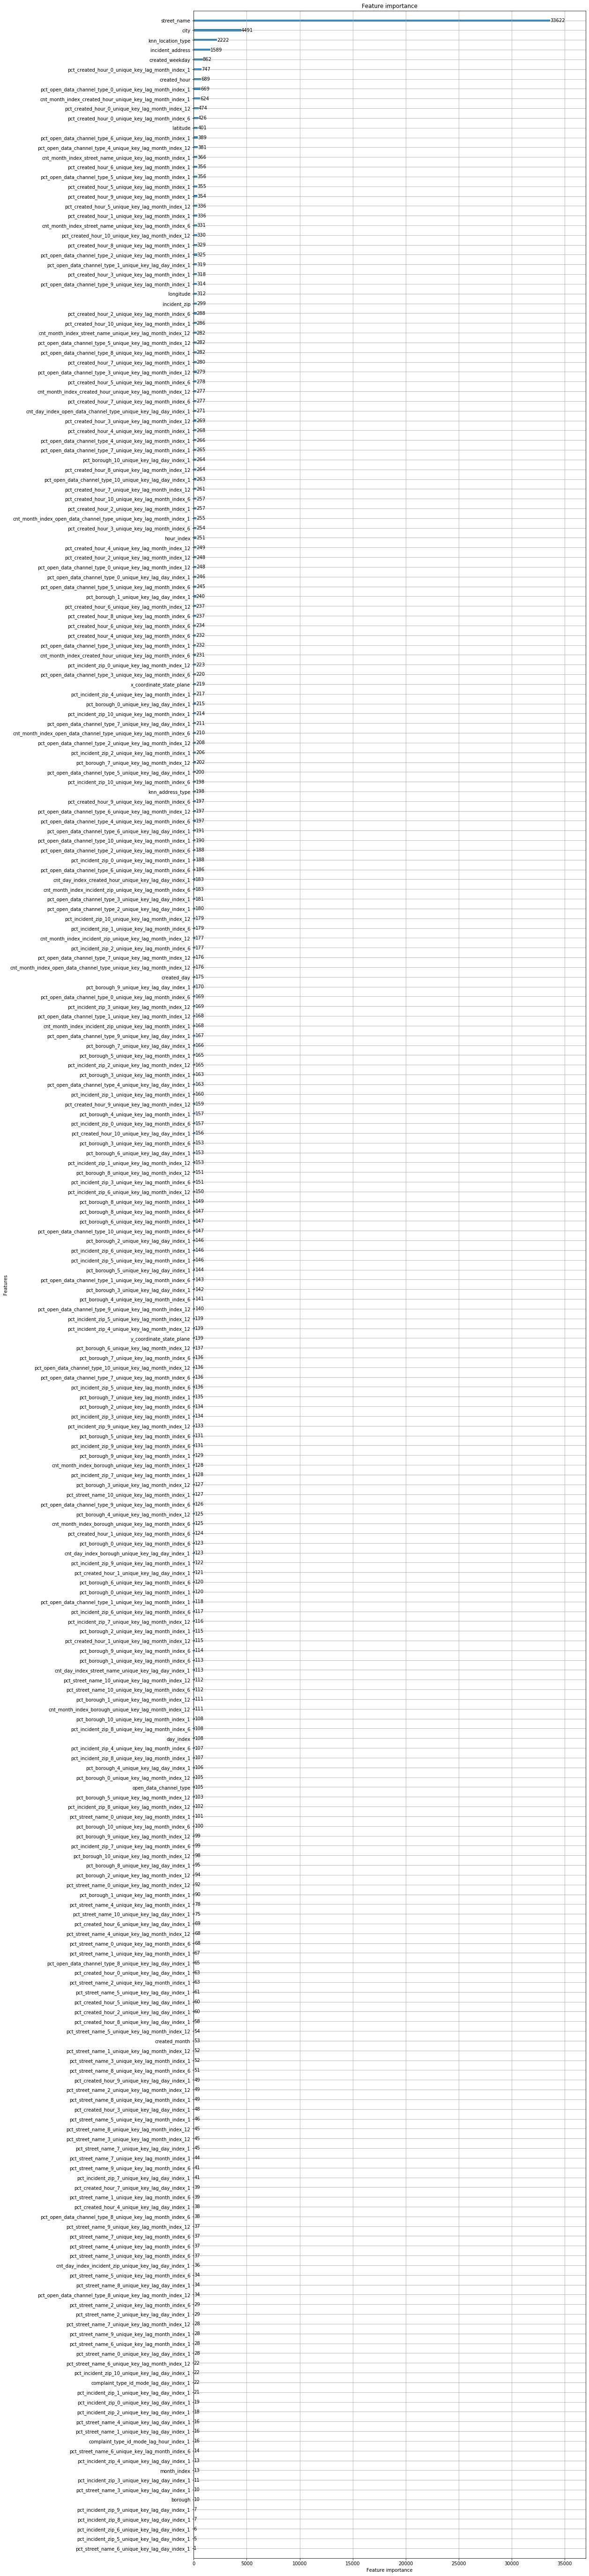

In [32]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,100))
plot_importance(booster=clf_sw, ax=ax)

# This is the end of the main section, in which I have
- extracted and cleaned the dataset
- performed exploratory data analysis to define the problem
- pre-processed the dataset
- performed feature engineering and selection
- trained and evaluated the ML model via LightGBM

# Section D. Appendix

The appendix contains a few methods that I tried, which justified my thought process as well as why I made the final choice as you have seen above.

It includes
- D1. "Raw" features only (Round 0)
- D2. Round 1 features ("raw" + engineered features except KNN)
- D3. Round 1.5 features (Round 1 + location_type)
- D4. Attempted different categorical variable treatment, namely target encoding
- D5. A LightGBM model to predict location_type (better than KNN)
- D6. A hierarchical complaint_type model using location_type predicted from lightGBM (not too helpful though...)

Note that Round 2 features (Round 1 + KNN) are eventually used, which is the one you saw in Section C.

### D1. Benchmark model (Round 0, with only "raw" features)

In [33]:
# time related features
feature_time = ['day_index', 'month_index', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

feature_target = ['complaint_type_id']

# feature selection: ONLY RAW features!!!!
x = df[feature_time + feature_location + feature_others + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')

x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 20}

# best parameters
opt_parameters = {'subsample': 0.9,
                  'feature_fraction': 0.9,
                  'learning_rate': 0.06,
                  'min_child_weight': 0.1,
                  'min_data_in_leaf': 70,
                  'num_leaves': 12,
                  'reg_alpha': 5,
                  'reg_lambda': 10} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 40 rounds.
[20]	train's multi_logloss: 1.64786	valid's multi_logloss: 1.71521
[40]	train's multi_logloss: 1.43644	valid's multi_logloss: 1.53308
[60]	train's multi_logloss: 1.34032	valid's multi_logloss: 1.4576
[80]	train's multi_logloss: 1.28459	valid's multi_logloss: 1.42125
[100]	train's multi_logloss: 1.24875	valid's multi_logloss: 1.40327
[120]	train's multi_logloss: 1.22334	valid's multi_logloss: 1.39457
[140]	train's multi_logloss: 1.20437	valid's multi_logloss: 1.38907
[160]	train's multi_logloss: 1.18944	valid's multi_logloss: 1.38507
[180]	train's multi_logloss: 1.17659	valid's multi_logloss: 1.38265
[200]	train's multi_logloss: 1.16582	valid's multi_logloss: 1.38076
[220]	train's multi_logloss: 1.15645	valid's multi_logloss: 1.38037
[240]	train's multi_logloss: 1.14767	valid's multi_logloss: 1.38053
[260]	train's multi_logloss: 1.14031	valid's multi_logloss: 1.38165
Early stopping, best iteration is:
[229]	train's multi_logl

LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.9, importance_type='split',
               learning_rate=0.06, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.1, min_data_in_leaf=70,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, nthread=4,
               num_class=11, num_leaves=12, objective='multiclass',
               random_state=2019, reg_alpha=5, reg_lambda=10, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
               verbosity=-1)

In [34]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.48      0.43      0.45      2911
               HEAT/HOT WATER       0.59      0.31      0.41      2562
              Illegal Parking       0.46      0.22      0.30      2334
             Blocked Driveway       0.36      0.21      0.27      1611
      Noise - Street/Sidewalk       0.54      0.18      0.27      1250
             Street Condition       0.41      0.21      0.28      1151
General Construction/Plumbing       0.27      0.02      0.03      1130
                 Water System       0.13      0.00      0.00       941
       Street Light Condition       0.67      0.57      0.62       523
         UNSANITARY CONDITION       0.22      0.01      0.02       883
                       Others       0.54      0.87      0.66     12427

                     accuracy                           0.52     27723
                    macro avg       0.43      0.28      0.30     27723
    

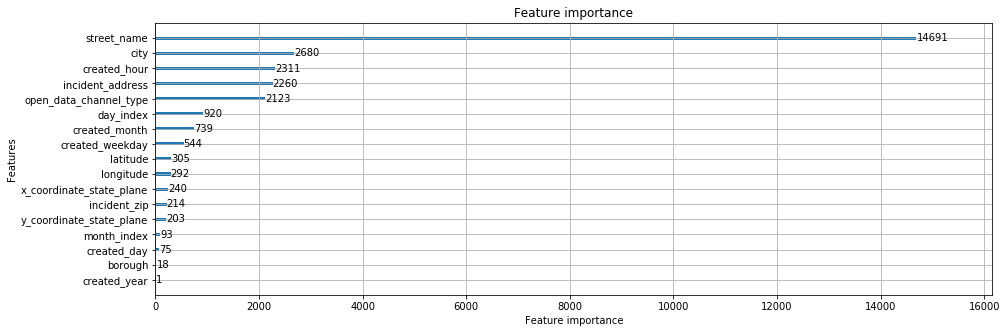

In [35]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,5))
plot_importance(booster=clf_sw, ax=ax)

### D2. Round 1 model ("raw" + lag features, without KNN features)

In [36]:
# time related features
feature_time = ['day_index', 'month_index', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

feature_target = ['complaint_type_id']

# feature selection: ONLY RAW features!!!!
x = df[feature_time + feature_location + feature_others + feature_mode_lag + feature_pct_lag + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')

x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 20}

# best parameters
opt_parameters = {'subsample': 0.63,
                  'feature_fraction': 0.92,
                  'learning_rate': 0.046,
                  'min_child_weight': 0.001,
                  'min_data_in_leaf': 32,
                  'num_leaves': 36,
                  'reg_alpha': 0,
                  'reg_lambda': 0.1} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 40 rounds.
[20]	train's multi_logloss: 1.6675	valid's multi_logloss: 1.75088
[40]	train's multi_logloss: 1.4239	valid's multi_logloss: 1.54793
[60]	train's multi_logloss: 1.29914	valid's multi_logloss: 1.4578
[80]	train's multi_logloss: 1.22248	valid's multi_logloss: 1.41176
[100]	train's multi_logloss: 1.1685	valid's multi_logloss: 1.38576
[120]	train's multi_logloss: 1.12864	valid's multi_logloss: 1.37219
[140]	train's multi_logloss: 1.09737	valid's multi_logloss: 1.36483
[160]	train's multi_logloss: 1.07195	valid's multi_logloss: 1.36093
[180]	train's multi_logloss: 1.05024	valid's multi_logloss: 1.3585
[200]	train's multi_logloss: 1.03104	valid's multi_logloss: 1.3575
[220]	train's multi_logloss: 1.01357	valid's multi_logloss: 1.35749
[240]	train's multi_logloss: 0.997434	valid's multi_logloss: 1.35878
Early stopping, best iteration is:
[206]	train's multi_logloss: 1.02571	valid's multi_logloss: 1.35738


LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.92, importance_type='split',
               learning_rate=0.046, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, nthread=4, num_class=11, num_leaves=36,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.1, silent=True, subsample=0.63,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [37]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.48      0.44      0.46      2911
               HEAT/HOT WATER       0.52      0.43      0.47      2562
              Illegal Parking       0.43      0.24      0.31      2334
             Blocked Driveway       0.35      0.22      0.27      1611
      Noise - Street/Sidewalk       0.54      0.24      0.33      1250
             Street Condition       0.43      0.17      0.25      1151
General Construction/Plumbing       0.25      0.02      0.03      1130
                 Water System       0.29      0.00      0.01       941
       Street Light Condition       0.65      0.59      0.62       523
         UNSANITARY CONDITION       0.16      0.01      0.01       883
                       Others       0.55      0.84      0.67     12427

                     accuracy                           0.53     27723
                    macro avg       0.42      0.29      0.31     27723
    

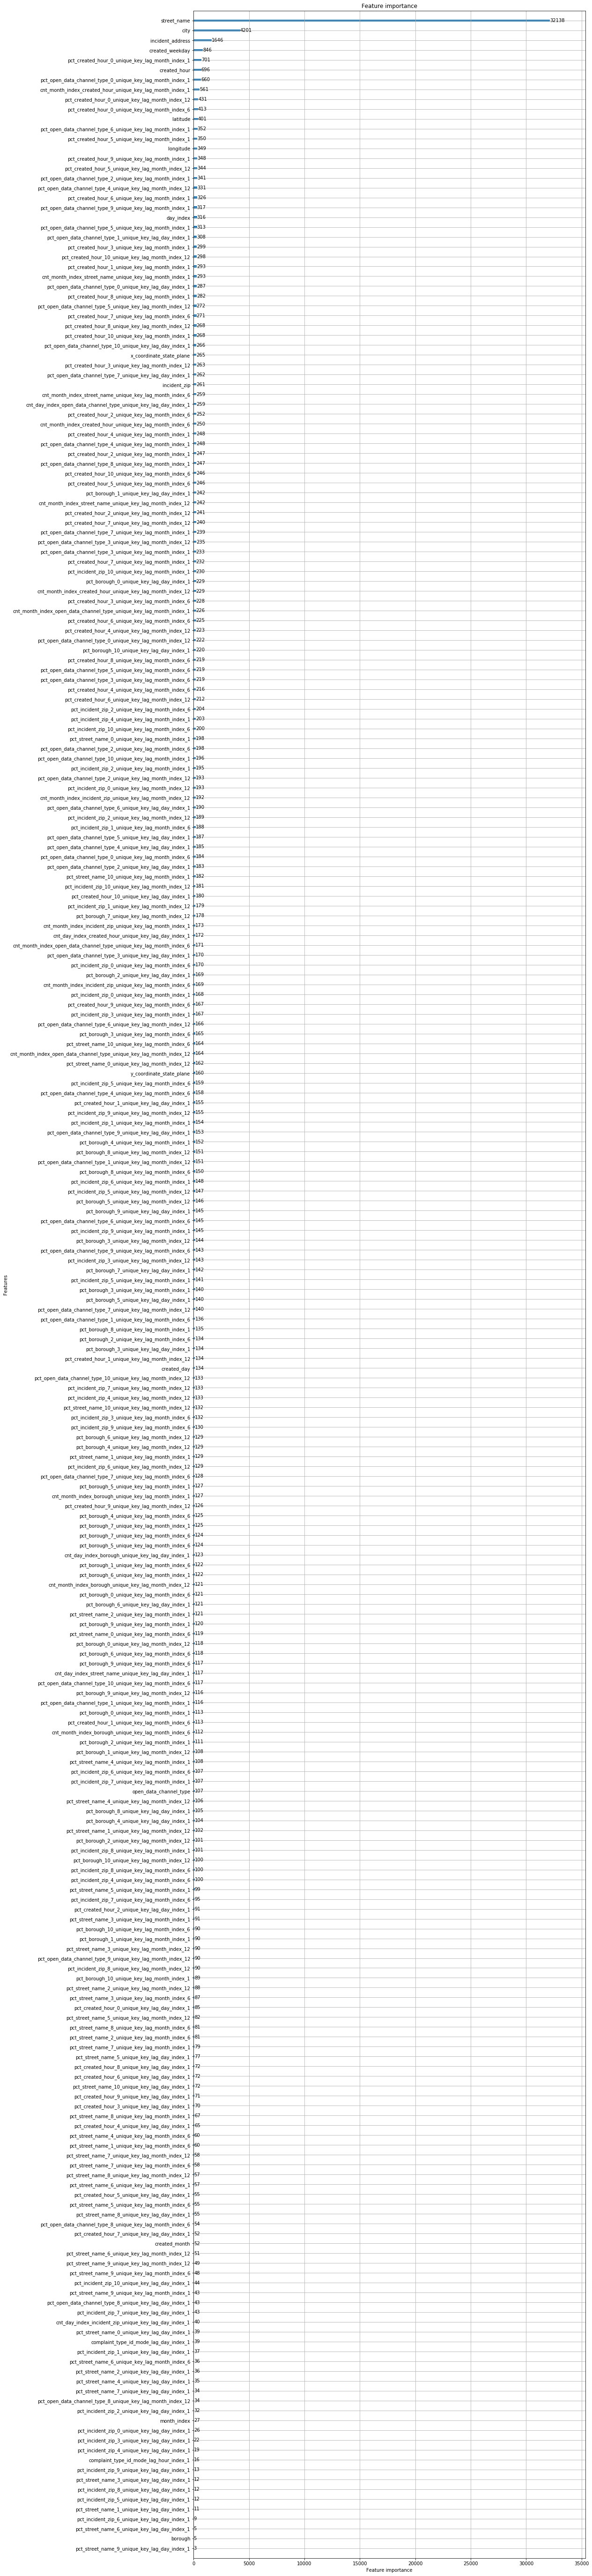

In [38]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,100))
plot_importance(booster=clf_sw, ax=ax)

### D3. Round 1.5 (Round 1 + 'location_type' +'address_type')

In [39]:
# time related features
feature_time = ['day_index', 'month_index', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address',
                    'location_type', 'address_type']

# other features
feature_others = ['open_data_channel_type']

feature_target = ['complaint_type_id']

# feature selection: ONLY RAW features!!!!
x = df[feature_time + feature_location + feature_others + feature_mode_lag + feature_pct_lag + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address', 'location_type', 'address_type']
for col in cat_features:
    x[col] = x[col].astype('category')

x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 20}

# best parameters
opt_parameters = {'subsample': 0.63,
                  'feature_fraction': 0.92,
                  'learning_rate': 0.046,
                  'min_child_weight': 0.001,
                  'min_data_in_leaf': 32,
                  'num_leaves': 36,
                  'reg_alpha': 0,
                  'reg_lambda': 0.1} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 40 rounds.
[20]	train's multi_logloss: 1.23618	valid's multi_logloss: 1.29936
[40]	train's multi_logloss: 0.90002	valid's multi_logloss: 0.996729
[60]	train's multi_logloss: 0.745817	valid's multi_logloss: 0.871711
[80]	train's multi_logloss: 0.66444	valid's multi_logloss: 0.817768
[100]	train's multi_logloss: 0.617161	valid's multi_logloss: 0.795954
[120]	train's multi_logloss: 0.586563	valid's multi_logloss: 0.787376
[140]	train's multi_logloss: 0.564323	valid's multi_logloss: 0.7844
[160]	train's multi_logloss: 0.546967	valid's multi_logloss: 0.782308
[180]	train's multi_logloss: 0.532308	valid's multi_logloss: 0.78362
Early stopping, best iteration is:
[153]	train's multi_logloss: 0.552814	valid's multi_logloss: 0.782131


LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.92, importance_type='split',
               learning_rate=0.046, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, nthread=4, num_class=11, num_leaves=36,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.1, silent=True, subsample=0.63,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [40]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.98      0.98      0.98      2911
               HEAT/HOT WATER       0.64      0.73      0.68      2562
              Illegal Parking       0.58      0.67      0.62      2334
             Blocked Driveway       0.57      0.53      0.55      1611
      Noise - Street/Sidewalk       0.65      0.67      0.66      1250
             Street Condition       0.56      0.27      0.37      1151
General Construction/Plumbing       0.31      0.02      0.04      1130
                 Water System       0.56      0.18      0.28       941
       Street Light Condition       0.69      0.72      0.71       523
         UNSANITARY CONDITION       0.29      0.02      0.04       883
                       Others       0.72      0.86      0.78     12427

                     accuracy                           0.70     27723
                    macro avg       0.60      0.51      0.52     27723
    

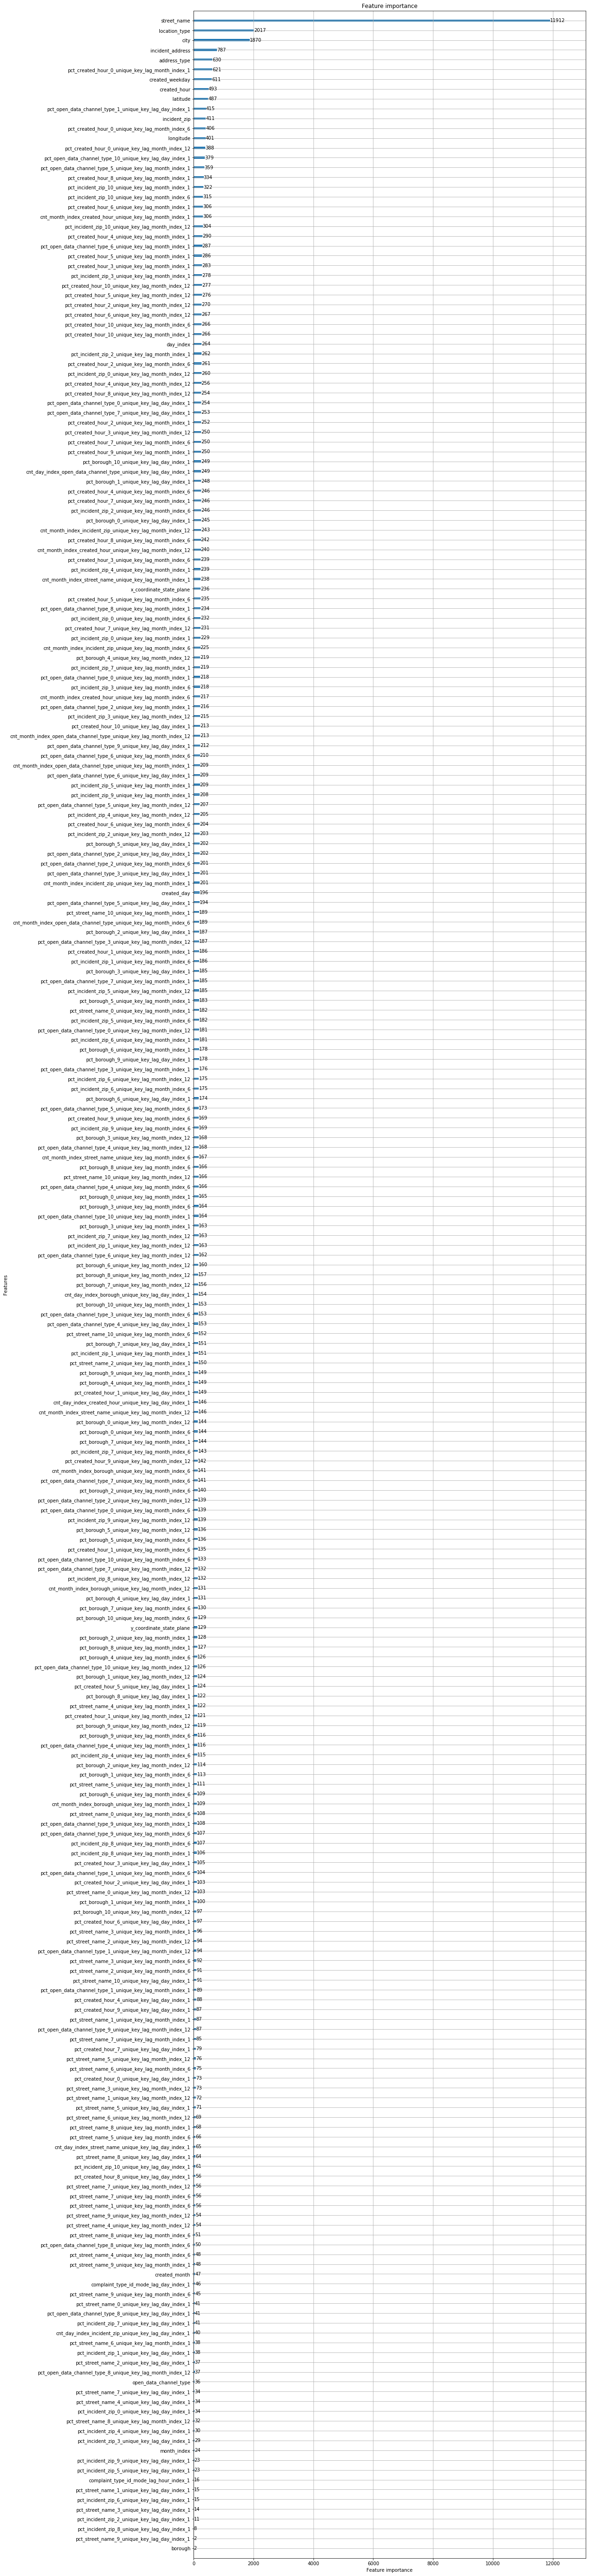

In [41]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,100))
plot_importance(booster=clf_sw, ax=ax)

### D4. Target Encoding

In [45]:
# time related features
feature_time = ['hour_index','day_index', 'month_index', 'created_year', 'created_month',
                'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

# knn features
feature_knn = ['knn_address_type', 'knn_location_type']

feature_target = ['complaint_type_id']

# feature selection
x = df[feature_time + feature_location + feature_others + feature_knn + feature_mode_lag + feature_pct_lag + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x[feature_mode_lag] = x[feature_mode_lag].fillna(-1.0)
x[feature_pct_lag] = x[feature_pct_lag].fillna(-1.0)
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')

x = x.reset_index(drop=True)

x_train = x[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]

In [46]:
# Mean encoding of the street name

street_name_dict = x_train.groupby(['street_name'])['complaint_type_id'].mean().to_dict()

x_train['street_name_id'] = x_train['street_name'].apply(lambda x : street_name_dict[x] if x in street_name_dict else -1)
x_test['street_name_id'] = x_test['street_name'].apply(lambda x : street_name_dict[x] if x in street_name_dict else -1)

y_train = x_train['complaint_type_id']
y_test = x_test['complaint_type_id']

x_train.drop(columns=['street_name', 'complaint_type_id'], inplace=True)
x_test.drop(columns=['street_name', 'complaint_type_id'], inplace=True)

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [47]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['valid'],
            'verbose': 100}

# best parameters
opt_parameters = {'subsample': 0.63,
                  'feature_fraction': 0.92,
                  'learning_rate': 0.046,
                  'min_child_weight': 0.001,
                  'min_data_in_leaf': 32,
                  'num_leaves': 36,
                  'reg_alpha': 0,
                  'reg_lambda': 0.1} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 40 rounds.
[100]	valid's multi_logloss: 1.17328	valid_1's multi_logloss: 1.37343
[200]	valid's multi_logloss: 1.05907	valid_1's multi_logloss: 1.35471
Early stopping, best iteration is:
[196]	valid's multi_logloss: 1.06218	valid_1's multi_logloss: 1.35468


LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.92, importance_type='split',
               learning_rate=0.046, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, nthread=4, num_class=11, num_leaves=36,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.1, silent=True, subsample=0.63,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [48]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.48      0.49      0.49      2911
               HEAT/HOT WATER       0.52      0.48      0.50      2562
              Illegal Parking       0.42      0.27      0.33      2334
             Blocked Driveway       0.39      0.23      0.29      1611
      Noise - Street/Sidewalk       0.56      0.25      0.34      1250
             Street Condition       0.43      0.17      0.25      1151
General Construction/Plumbing       0.25      0.00      0.00      1130
                 Water System       0.33      0.01      0.01       941
       Street Light Condition       0.65      0.55      0.60       523
         UNSANITARY CONDITION       0.28      0.01      0.02       883
                       Others       0.56      0.83      0.67     12427

                     accuracy                           0.53     27723
                    macro avg       0.44      0.30      0.32     27723
    

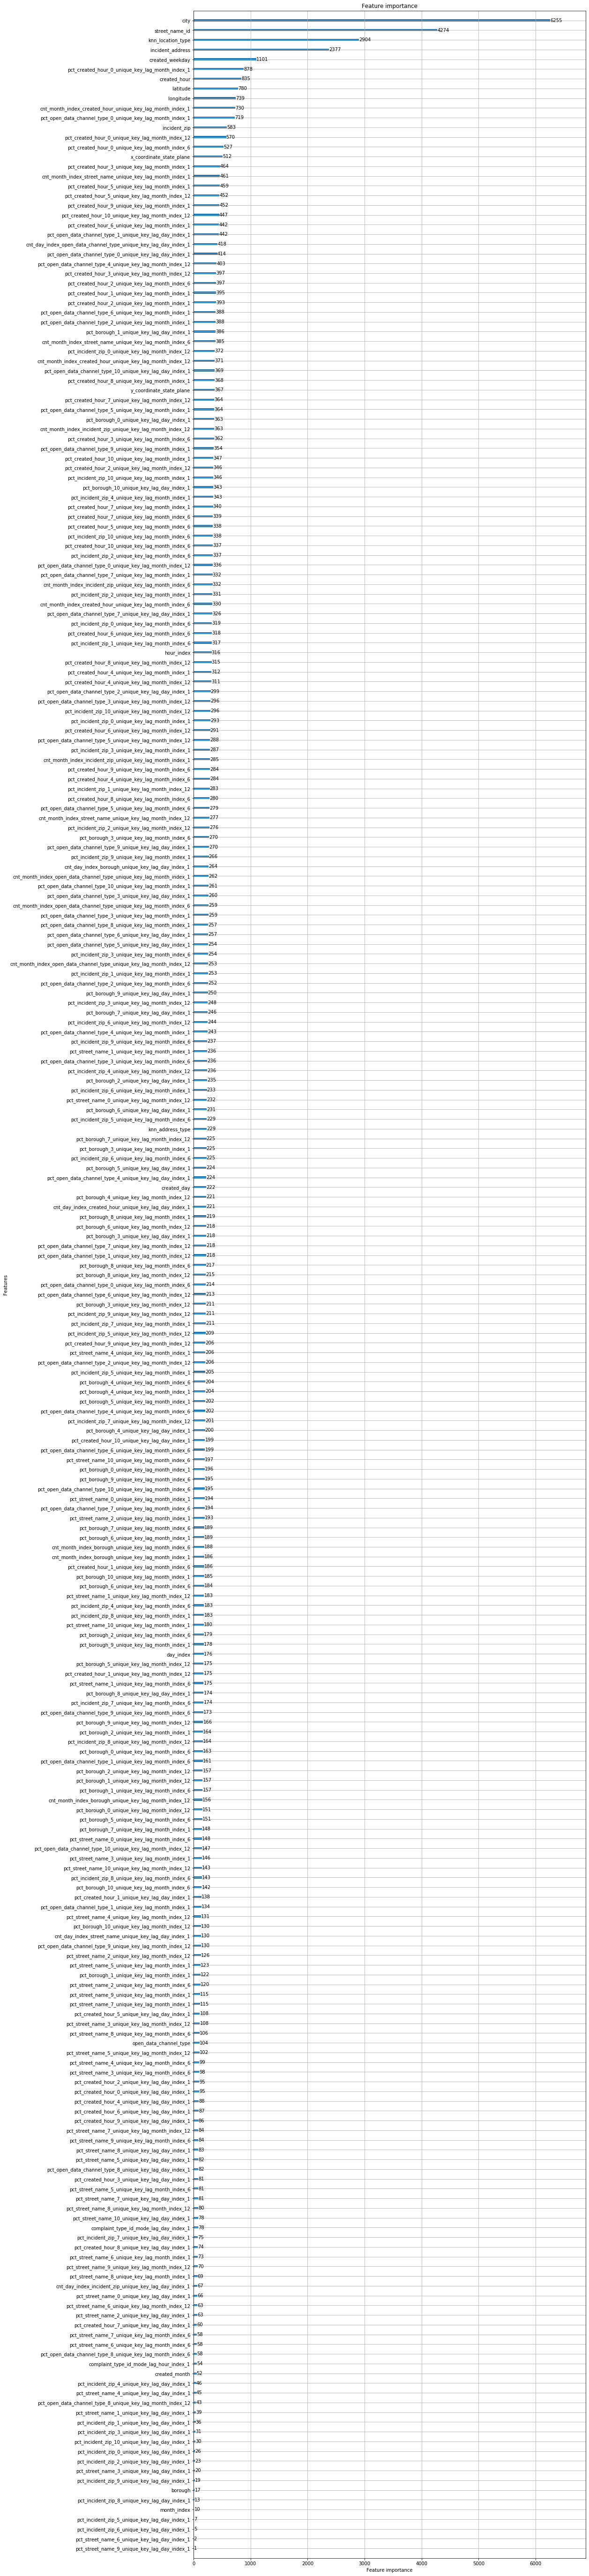

In [49]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,100))
plot_importance(booster=clf_sw, ax=ax)

### D5. A better model to predict location_type

#### Idea
- Location_type is critical in predicting the complaint_type
- However, the KNN model only has 35% accuracy for predicting location_type
- Let us set up an LightGBM model to predict location_type first, and then use the predicted location_type to predict the complaint_type

#### Result
- This model achieved 67% accuracy of predicting location_type, better than the 35% accuracy KNN model

In [50]:
df_location = df_knn.copy()

In [51]:
# create datetime related features
df_location['created_year'] = df_location['created_date'].dt.year
df_location['created_month'] = df_location['created_date'].dt.month
df_location['created_day'] = df_location['created_date'].dt.day
df_location['created_hour'] = df_location['created_date'].dt.hour
df_location['created_weekday'] = df_location['created_date'].dt.weekday

# fill NA
df_location['incident_zip'] = df_location['incident_zip'].fillna(-1)

df_location['month_index'] = df_location['created_year'] * 12 + df_location['created_month']
df_location['month_index'] = df_location['month_index'] - df_location['month_index'].min()

df_location['day_index'] = (df_location['created_date'] - df_location['created_date'].min()).dt.days

Let's look at the top location_type

In [52]:
location_count = df_location.groupby(['location_type'])['unique_key'].count().reset_index()
location_count = location_count.sort_values(by=['unique_key'], ascending=False).reset_index(drop=True)
location_count.columns = ['location_type', 'count']
location_count.head(10)

location_type  count
0        RESIDENTIAL BUILDING  65534
1                              52701
2             Street/Sidewalk  43105
3  Residential Building/House  24895
4                      Street  23283
5                    Sidewalk  21187
6            Store/Commercial   3327
7         Club/Bar/Restaurant   2313
8     3+ Family Apt. Building   1553
9  Restaurant/Bar/Deli/Bakery   1308

There are a few duplicate items. Let us group then together

In [53]:
location_dict = {'RESIDENTIAL BUILDING':       0,
                 'Residential Building/House': 0,
                 '3+ Family Apt. Building':    0,
                 '':                           1,
                 'Street/Sidewalk':            2,
                 'Street':                     2,
                 'Sidewalk':                   2,
                 'Store/Commercial':           3,
                 'Club/Bar/Restaurant':        3,
                 'Restaurant/Bar/Deli/Bakery': 3
                }

num = 4

df_location['location_type'] = df_location['location_type'].apply(lambda x : location_dict[x] if x in location_dict else len(location_dict))
location_count['cum_ratio'] = (location_count['count'] / location_count['count'].sum()).cumsum(axis = 0)
print("%.1f%% of the complaints are covered in the top %d types" % (100*location_count.iloc[num]['cum_ratio'], num))

location_dict

83.8% of the complaints are covered in the top 4 types


{'RESIDENTIAL BUILDING': 0,
 'Residential Building/House': 0,
 '3+ Family Apt. Building': 0,
 '': 1,
 'Street/Sidewalk': 2,
 'Street': 2,
 'Sidewalk': 2,
 'Store/Commercial': 3,
 'Club/Bar/Restaurant': 3,
 'Restaurant/Bar/Deli/Bakery': 3}

In [54]:
# time related features
feature_time = ['day_index', 'month_index', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

feature_target = ['location_type']

# feature selection
x = df_location[feature_time + feature_location + feature_others + feature_target]

# clean up data
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')

x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 20}

# best parameters
opt_parameters = {'subsample': 0.8,
                  'feature_fraction': 0.9,
                  'learning_rate': 0.03,
                  'min_child_weight': 0.1,
                  'min_data_in_leaf': 50,
                  'num_leaves': 15,
                  'reg_alpha': 5,
                  'reg_lambda': 10} 

clf_location = lgb.LGBMClassifier(**params)
clf_location.set_params(**opt_parameters)
clf_location.fit(x_train, y_train, **fit_params)

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Training until validation scores don't improve for 40 rounds.
[20]	train's multi_logloss: 1.21999	valid's multi_logloss: 1.26736
[40]	train's multi_logloss: 1.04398	valid's multi_logloss: 1.11695
[60]	train's multi_logloss: 0.947997	valid's multi_logloss: 1.03748
[80]	train's multi_logloss: 0.891052	valid's multi_logloss: 0.992574
[100]	train's multi_logloss: 0.855547	valid's multi_logloss: 0.966139
[120]	train's multi_logloss: 0.830952	valid's multi_logloss: 0.949515
[140]	train's multi_logloss: 0.812492	valid's multi_logloss: 0.937762
[160]	train's multi_logloss: 0.79806	valid's multi_logloss: 0.930299
[180]	train's multi_logloss: 0.786497	valid's multi_logloss: 0.924805
[200]	train's multi_logloss: 0.776868	valid's multi_logloss: 0.920521
[220]	train's multi_logloss: 0.768723	valid's multi_logloss: 0.917224
[240]	train's multi_logloss: 0.761821	valid's multi_logloss: 0.914287
[260]	train's multi_logloss: 0.755868	valid's multi_logloss: 0.912209
[280]	train's multi_logloss: 0.750843	

LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.9, importance_type='split',
               learning_rate=0.03, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.1, min_data_in_leaf=50,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, nthread=4,
               num_class=5, num_leaves=15, objective='multiclass',
               random_state=2019, reg_alpha=5, reg_lambda=10, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbosity=-1)

In [55]:
%%time

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy of the location_type prediction model is %.2f\n" % accuracy_score(y_test, clf_location.predict(x_test)))
print(classification_report(y_test,
                            clf_location.predict(x_test),
                            labels=range(len(location_dict)+1),
                            target_names=list(location_dict)+['Others']))

Accuracy of the location_type prediction model is 0.66

                            precision    recall  f1-score   support

      RESIDENTIAL BUILDING       0.62      0.70      0.66      9447
Residential Building/House       0.84      0.63      0.72      6595
   3+ Family Apt. Building       0.64      0.76      0.69     13078
                                 0.43      0.18      0.25       753
           Street/Sidewalk       0.00      0.00      0.00         0
                    Street       0.00      0.00      0.00         0
                  Sidewalk       0.00      0.00      0.00         0
          Store/Commercial       0.00      0.00      0.00         0
       Club/Bar/Restaurant       0.00      0.00      0.00         0
Restaurant/Bar/Deli/Bakery       0.00      0.00      0.00         0
                    Others       0.28      0.02      0.04      1597

                 micro avg       0.66      0.66      0.66     31470
                 macro avg       0.26      0.21      0.22 

C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ZhouM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


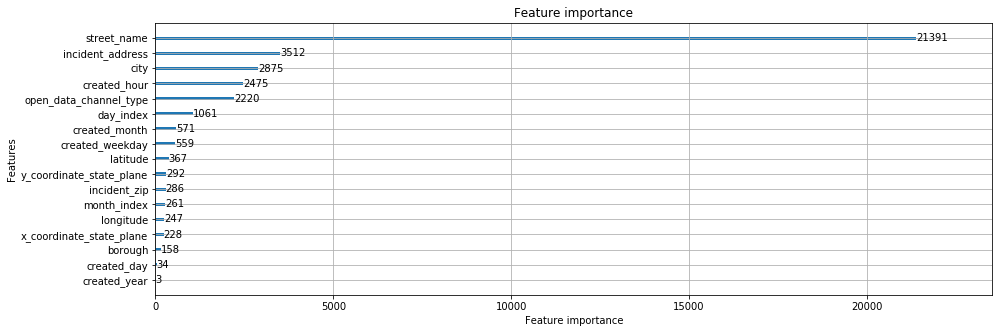

In [56]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(15,5))
plot_importance(booster=clf_location, ax=ax)

### D6. Hierarical complaint_type model using the lightGBM location_type model

In [57]:
# time related features
feature_time = ['day_index', 'month_index', 'created_year', 'created_month',
                'created_day', 'created_hour', 'created_weekday']

# location related features
feature_location = ['incident_zip', 'street_name', 'city', 'borough', 'latitude', 'longitude',
                    'x_coordinate_state_plane', 'y_coordinate_state_plane', 'incident_address']

# other features
feature_others = ['open_data_channel_type']

feature_target = ['complaint_type_id']

# feature selection
x = df[feature_time + feature_location + feature_others + feature_knn + feature_mode_lag + feature_pct_lag + feature_target]

# remove the first year data due to 12-month lag
x = x[x['created_year'] >= 2015]

# clean up data
x[feature_mode_lag] = x[feature_mode_lag].fillna(-1.0)
x[feature_pct_lag] = x[feature_pct_lag].fillna(-1.0)
x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

# set up categorical features
cat_features = ['street_name', 'city', 'borough', 'open_data_channel_type', 'incident_address']
for col in cat_features:
    x[col] = x[col].astype('category')

x['lightgbm_location_type_id'] = clf_location.predict(x[feature_time + feature_location + feature_others])
    
x = x.reset_index(drop=True)
y = x[feature_target]
x = x.drop(columns=feature_target)

In [58]:
x_train = x[(x['created_year'] < 2019)]
y_train = y[(x['created_year'] < 2019)]
x_test = x[(x['created_year'] == 2019)]
y_test = y[(x['created_year'] == 2019)]

# Fixed parameters
params = {'n_estimators':5000,
          'objective': 'multiclass',
          'num_class': len(np.unique(y.values)),
          'max_depth': -1,
          "boosting": "gbdt",
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "nthread": 4,
          'metric': 'multi_logloss',
          "random_state": 2019,
          }

        
# Model training parameters
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(x_train, y_train), (x_test, y_test)],
            'eval_names': ['train', 'valid'],
            'verbose': 20}

# best parameters
opt_parameters = {'subsample': 0.63,
                  'feature_fraction': 0.92,
                  'learning_rate': 0.046,
                  'min_child_weight': 0.001,
                  'min_data_in_leaf': 32,
                  'num_leaves': 36,
                  'reg_alpha': 0,
                  'reg_lambda': 0.1} 

clf_sw = lgb.LGBMClassifier(**params)
clf_sw.set_params(**opt_parameters)
clf_sw.fit(x_train, y_train, **fit_params)

Training until validation scores don't improve for 40 rounds.
[20]	train's multi_logloss: 1.65038	valid's multi_logloss: 1.73051
[40]	train's multi_logloss: 1.40071	valid's multi_logloss: 1.52034
[60]	train's multi_logloss: 1.27365	valid's multi_logloss: 1.42794
[80]	train's multi_logloss: 1.19591	valid's multi_logloss: 1.381
[100]	train's multi_logloss: 1.14125	valid's multi_logloss: 1.35458
[120]	train's multi_logloss: 1.10063	valid's multi_logloss: 1.34099
[140]	train's multi_logloss: 1.06932	valid's multi_logloss: 1.33331
[160]	train's multi_logloss: 1.0437	valid's multi_logloss: 1.32917
[180]	train's multi_logloss: 1.02203	valid's multi_logloss: 1.32681
[200]	train's multi_logloss: 1.00321	valid's multi_logloss: 1.3261
[220]	train's multi_logloss: 0.985962	valid's multi_logloss: 1.32589
[240]	train's multi_logloss: 0.970158	valid's multi_logloss: 1.32642
[260]	train's multi_logloss: 0.955438	valid's multi_logloss: 1.32697
Early stopping, best iteration is:
[220]	train's multi_logl

LGBMClassifier(bagging_freq=1, bagging_seed=11, boosting='gbdt',
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.92, importance_type='split',
               learning_rate=0.046, max_depth=-1, metric='multi_logloss',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, nthread=4, num_class=11, num_leaves=36,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.1, silent=True, subsample=0.63,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [59]:
%%time

from sklearn.metrics import classification_report

print(classification_report(y_test,
                            clf_sw.predict(x_test),
                            labels=range(len(cat_dict)+1),
                            target_names=list(cat_dict)+['Others']))

                               precision    recall  f1-score   support

          Noise - Residential       0.52      0.47      0.50      2911
               HEAT/HOT WATER       0.53      0.47      0.50      2562
              Illegal Parking       0.46      0.26      0.34      2334
             Blocked Driveway       0.37      0.24      0.30      1611
      Noise - Street/Sidewalk       0.55      0.25      0.35      1250
             Street Condition       0.43      0.18      0.25      1151
General Construction/Plumbing       0.21      0.01      0.03      1130
                 Water System       0.25      0.01      0.01       941
       Street Light Condition       0.65      0.58      0.61       523
         UNSANITARY CONDITION       0.13      0.01      0.01       883
                       Others       0.56      0.84      0.67     12427

                     accuracy                           0.54     27723
                    macro avg       0.43      0.30      0.32     27723
    